# Promote Employee Or Not Classifier (Using XGBoost)

Dataset Source: https://www.kaggle.com/arashnic/hr-ana

#### Notes about Results:

1) In addition to running the XGBoost Classifier on this dataset, I ran a Keras Neural Network on it as well. The XGBoost Classifier performed much better than the Keras Model.

2) Originally, I was using undersampling as I thought there were enough samples. Once I switched to using oversampling (SMOTE), results improved considerably.

3) When I first used the 'scale_pos_weight', I wished there was a way to use a middle point between the full scale weight and no scale. Naturally, I tried dividing the scaled value in half. It worked well, but I continued tuning the value to what it is now.

4) I am aware that there are tools, like Weights and Biases, to automate fine tunning XGBoost models. In time, I may very well take advantage of those tools and write a function to fine tune this model further.


#### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

import xgboost as xgb
from xgboost import XGBClassifier, plot_tree

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import sys

/Users/briandunn/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Versions of Main Libraries

In [2]:
print('pandas:', pd.__version__)
print('numPy:', np.__version__)
print("python3:", sys.version[0:6])
print('XGBoost:', xgb.__version__)

pandas: 1.4.2
numPy: 1.21.5
python3: 3.9.12
XGBoost: 1.5.0


#### Import  & Preprocess Data

In [3]:
data = pd.read_csv('train.csv')

# Data Preprocessing
data.dropna(inplace=True)
data.rename(columns={'gender' : 'is_male', 'awards_won?' : 'awards_won', 'is_promoted' : 'target'}, inplace=True)
data['is_male'].replace({'m' : 1, 'f': 0}, inplace=True)
data.drop(columns=['employee_id'], inplace=True)

# Remove outliers using the 'IQR * 1.5' rule
def remove_outliers(df, feature):
    q1, q3 = np.percentile(df[feature], [25,75])
    iqr = q3-q1
    ul = q3 + (iqr * 1.5)
    ll = q1 - (iqr * 1.5)
    neo_data = df[(df[feature].values > ll) & (df[feature].values < ul)]
    return neo_data

data = remove_outliers(data, 'length_of_service')
data = remove_outliers(data, 'age')

data.describe()

,is_male,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,target
count,44303.000000,44303.000000,44303.000000,44303.000000,44303.000000,44303.000000,44303.000000,44303.000000
mean,0.697537,1.260276,33.961018,3.339368,5.565560,0.023678,63.726317,0.088730
std,0.459330,0.610277,5.542368,1.260114,2.964149,0.152045,13.361678,0.284357
min,0.000000,1.000000,20.000000,1.000000,1.000000,0.000000,39.000000,0.000000
25%,0.000000,1.000000,30.000000,3.000000,3.000000,0.000000,52.000000,0.000000
50%,1.000000,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,1.000000,1.000000,38.000000,4.000000,7.000000,0.000000,76.000000,0.000000
max,1.000000,10.000000,49.000000,5.000000,15.000000,1.000000,99.000000,1.000000


In [4]:
awards_target = data[['awards_won', 'age', 'length_of_service', 'target']]
print(awards_target.corr())

                   awards_won       age  length_of_service    target
awards_won           1.000000 -0.004798          -0.041383  0.195741
age                 -0.004798  1.000000           0.516738 -0.011927
length_of_service   -0.041383  0.516738           1.000000 -0.006701
target               0.195741 -0.011927          -0.006701  1.000000


#### Drop 'Age' Feature Since Low correlation & Legally Cannot Discriminate Against People 40+ Years Old

In [5]:
data.drop(columns=['age'], inplace=True)
data.describe()

,is_male,no_of_trainings,previous_year_rating,length_of_service,awards_won,avg_training_score,target
count,44303.000000,44303.000000,44303.000000,44303.000000,44303.000000,44303.000000,44303.000000
mean,0.697537,1.260276,3.339368,5.565560,0.023678,63.726317,0.088730
std,0.459330,0.610277,1.260114,2.964149,0.152045,13.361678,0.284357
min,0.000000,1.000000,1.000000,1.000000,0.000000,39.000000,0.000000
25%,0.000000,1.000000,3.000000,3.000000,0.000000,52.000000,0.000000
50%,1.000000,1.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,1.000000,1.000000,4.000000,7.000000,0.000000,76.000000,0.000000
max,1.000000,10.000000,5.000000,15.000000,1.000000,99.000000,1.000000


#### Return Unique Values in Each Feature

In [6]:
for x in data.columns:
    print('Feature Name:', x, '\nNumber of Unique Values: ', len(data[x].unique()))
    print(data[x].unique(), '\n')

Feature Name: department 
Number of Unique Values:  9
['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal'] 

Feature Name: region 
Number of Unique Values:  34
['region_7' 'region_22' 'region_19' 'region_23' 'region_26' 'region_2'
 'region_20' 'region_34' 'region_1' 'region_4' 'region_31' 'region_15'
 'region_14' 'region_11' 'region_5' 'region_28' 'region_13' 'region_16'
 'region_25' 'region_29' 'region_10' 'region_27' 'region_30' 'region_12'
 'region_21' 'region_17' 'region_32' 'region_6' 'region_33' 'region_8'
 'region_24' 'region_3' 'region_9' 'region_18'] 

Feature Name: education 
Number of Unique Values:  3
["Master's & above" "Bachelor's" 'Below Secondary'] 

Feature Name: is_male 
Number of Unique Values:  2
[0 1] 

Feature Name: recruitment_channel 
Number of Unique Values:  3
['sourcing' 'other' 'referred'] 

Feature Name: no_of_trainings 
Number of Unique Values:  10
[ 1  2  3  4  7  5  6  8  9 10] 

Feature Name: previous_y

#### Split Data into Train & Test Datasets

In [7]:
y = data['target']
X = data.loc[:, data.columns != 'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

#### Determine Weights (Imbalanced Data)

In [8]:
counter = np.bincount(y_train)

imbal_ratio = counter[0]/counter[1]
print('''The ratio of non-promoted employees to promoted individuals is %.4f 
employees not promoted to every one employee that is promoted''' % (imbal_ratio))

The ratio of non-promoted employees to promoted individuals is 10.2693 
employees not promoted to every one employee that is promoted


#### Parameters for Model

In [9]:
params = {'booster':'dart',
          'base_score':.10,
          'use_label_encoder': False,
          'n_estimators':100,
          'reg_alpha':0.50,
          'reg_lambda':0.50,
          'learning_rate':0.1175, 
          'scale_pos_weight':imbal_ratio/3,
          'random_state':42,
          'verbosity':3,
          'tree_method':'approx', 
          'eval_metric':['error', 'auc'],
          'objective':'binary:logistic'}

#### Create Column Transformer

In [10]:
# Create ColumnTransformer
oneHotFeatures = ['department', 
                  'region', 
                  'education', 
                  'is_male', 
                  'recruitment_channel']

ordinalFeatures = ['awards_won', 
                   'avg_training_score', 
                   'previous_year_rating', 
                   'length_of_service', 
                   'no_of_trainings']

ohe = OneHotEncoder()
ord_en = OrdinalEncoder()

ct = ColumnTransformer([("OHE", ohe, oneHotFeatures), 
                        ("Ordinal", ord_en, ordinalFeatures)], 
                       remainder='passthrough')

#### Instantiate Model

In [11]:
model = XGBClassifier(**params)

#### Create Pipeline

In [12]:
# Instantiate SMOTE Transformer
smote = SMOTE(random_state=42, sampling_strategy='all')

# Build Pipeline
pipeline = Pipeline([('coltran', ct), 
                     ('imblearn', smote), 
                     ('xgb_classifier', model)])

#### Fit Pipeline

In [13]:
pipeline.fit(X_train, y_train)

[19:55:25] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[19:55:25] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/gbm/gbtree.cc:904: drop 0 trees, weight = 1
[19:55:25] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[19:55:25] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/gbm/gbtree.cc:904: drop 0 trees, weight = 1
[19:55:26] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned node

[19:55:27] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[19:55:27] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/gbm/gbtree.cc:904: drop 0 trees, weight = 1
[19:55:27] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[19:55:27] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/gbm/gbtree.cc:904: drop 0 trees, weight = 1
[19:55:28] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned node

[19:55:31] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[19:55:31] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/gbm/gbtree.cc:904: drop 0 trees, weight = 1
[19:55:31] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[19:55:31] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/gbm/gbtree.cc:904: drop 0 trees, weight = 1
[19:55:32] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned node

[19:55:37] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[19:55:37] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/gbm/gbtree.cc:904: drop 0 trees, weight = 1
[19:55:37] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[19:55:37] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/gbm/gbtree.cc:904: drop 0 trees, weight = 1
[19:55:37] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned node

[19:55:44] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[19:55:44] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/gbm/gbtree.cc:904: drop 0 trees, weight = 1
[19:55:44] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[19:55:44] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/gbm/gbtree.cc:904: drop 0 trees, weight = 1
[19:55:45] INFO: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned node

Pipeline(steps=[('coltran',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE', OneHotEncoder(),
                                                  ['department', 'region',
                                                   'education', 'is_male',
                                                   'recruitment_channel']),
                                                 ('Ordinal', OrdinalEncoder(),
                                                  ['awards_won',
                                                   'avg_training_score',
                                                   'previous_year_rating',
                                                   'length_of_service',
                                                   'no_of_trainings'])])),
                ('imblearn', SMOTE(random_state=42, sampling_str...
                               importance_type=None, interaction_constraints='',
                        

#### Evaluation Results (for Each Iteration)

In [14]:
pipeline.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0])

#### Feature Importances'

In [15]:
pipeline['xgb_classifier'].feature_importances_

array([8.58348329e-03, 7.58963916e-03, 1.01388036e-03, 4.61219825e-05,
       3.34457681e-02, 2.06251610e-02, 6.59293029e-03, 2.58189887e-02,
       2.74783894e-02, 5.93592180e-03, 8.40826798e-03, 1.58877969e-02,
       3.29732010e-03, 4.12000194e-02, 1.24182282e-02, 3.37543264e-02,
       2.02629771e-02, 1.19080888e-02, 0.00000000e+00, 1.33289453e-02,
       4.08745743e-02, 1.16613535e-02, 2.77783023e-03, 3.41806114e-02,
       1.93647109e-02, 4.65204148e-03, 1.61072873e-02, 3.05579156e-02,
       2.49397606e-02, 1.36389351e-02, 3.64524638e-03, 4.82989848e-03,
       1.15249883e-02, 2.42351796e-02, 9.37281735e-03, 0.00000000e+00,
       0.00000000e+00, 3.12661417e-02, 4.70526842e-03, 1.21245021e-02,
       3.91258337e-02, 1.29467258e-02, 0.00000000e+00, 4.01821882e-02,
       0.00000000e+00, 1.68646686e-02, 4.82366085e-02, 0.00000000e+00,
       3.67584564e-02, 4.13920172e-03, 4.29982170e-02, 2.53031161e-02,
       1.70322079e-02, 7.80518800e-02, 3.43271322e-03, 3.68727744e-02],
     

#### All Parameters for Model

In [16]:
pipeline['xgb_classifier'].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.1,
 'booster': 'dart',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1175,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'scale_pos_weight': 3.423105458399576,
 'subsample': 1,
 'tree_method': 'approx',
 'validate_parameters': 1,
 'verbosity': 3,
 'eval_metric': ['error', 'auc']}

#### Make Predictions

In [17]:
y_pred = pipeline.predict(X_test)
predictions = [round(value) for value in y_pred]

#### Classification Report

In [18]:
target_names = ['Not Promoted', 'Promoted']
print(classification_report(y_test, predictions, digits=4, target_names=target_names))

              precision    recall  f1-score   support

Not Promoted     0.9461    0.9472    0.9467      8075
    Promoted     0.4510    0.4453    0.4481       786

    accuracy                         0.9027      8861
   macro avg     0.6986    0.6963    0.6974      8861
weighted avg     0.9022    0.9027    0.9024      8861



#### Confusion Matrix

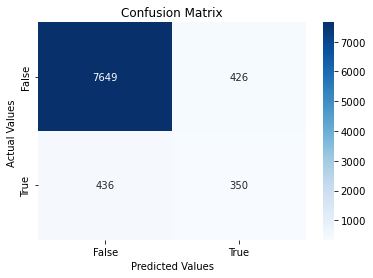

In [19]:
cm = confusion_matrix(y_test, predictions, labels=[0, 1])

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

#### Print ROC AUC Score

In [20]:
print("The ROC AUC Score: {}".format(round(100*roc_auc_score(y_test, predictions),2)))

The ROC AUC Score: 69.63


#### Save Model

In [21]:
model.save_model("~/Documents/XGBClassifier-HR Promotion-Imbalance_corrected.json")

#### Generate Tree from Model

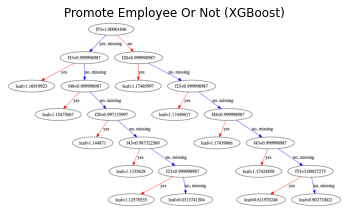

In [22]:
model_tree=plot_tree(pipeline['xgb_classifier'], 
          ratio="1")

plt.title('Promote Employee Or Not (XGBoost)')
plt.show()

#### Save Model Tree to File

In [23]:
format = 'jpeg'

image = xgb.to_graphviz(pipeline['xgb_classifier'])

image.graph_attr = {'dpi':'400'}

image.render('/Users/briandunn/Desktop/Pictures/PromoteEmployeeOrNot-XGBoost', format=format)

'/Users/briandunn/Desktop/Pictures/PromoteEmployeeOrNot-XGBoost.jpeg'